# IMFBCF

## Packages

### Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

### Customized functions

In [2]:
# Filter dataframe by date range or for two specific dates
def date_selection(data_frame,first_date,last_date,inbewtween):
    if inbewtween==True:
        data_frame = data_frame[(data_frame["date"] >= first_date) & (data_frame["date"] <= last_date)].reset_index(drop = True)
    else:
        data_frame = data_frame[(data_frame["date"] == first_date) | (data_frame["date"] == last_date)].reset_index(drop = True)
    return(data_frame)

# Return last date for any dataframe with a 'date' columns
def last_date(dataframe):
    x= dataframe['date'].tail(1).dt.strftime('%Y-%m-%d').to_string()[-10:]
    return(x)

### Fonts

In [3]:
#n Load new fonts
# Load the Comfortaa style

path = [x for x in sys.path if "assets" in x][0] + "\\fonts\\Teko\\"

for x in os.listdir(path):
    if x.split(".")[-1] == "ttf":
        fm.fontManager.addfont(path + "/" + x)
        try:
            fm.FontProperties(weight=x.split(
                "-")[-1].split(".")[0].lower(), fname=x)
        except:
            x

path = [x for x in sys.path if "assets" in x][0] + "\\fonts\\Dosis\\"

for x in os.listdir(path):
    if x.split(".")[-1] == "ttf":
        fm.fontManager.addfont(path + "/" + x)
        try:
            fm.FontProperties(weight=x.split(
                "-")[-1].split(".")[0].lower(), fname=x)
        except:
            x

## Data

### Payload

In [4]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type"
    ],
    "categories": {
        "adjustment_type": [
            "61060325ab095ed"
        ],
        "economic_activity": [
            "761bc00426e1c48"
        ],
        "origin_type": [
            "a4aa186f67755cb"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_imfbcf",
            "variables": [
                "01a24841a9090de"
            ]
        }
    ],
    "from": "1993-01-03"
}

response = get_tukan_api_request(payload)
imfbcf = response["data"]
imfbcf

Success getting the data


,date,adjustment_type__ref,adjustment_type,01a24841a9090de
0,1993-01-01,61060325ab095ed,Ajuste estacional,59.506704
1,1993-02-01,61060325ab095ed,Ajuste estacional,61.361901
2,1993-03-01,61060325ab095ed,Ajuste estacional,60.940503
3,1993-04-01,61060325ab095ed,Ajuste estacional,60.240003
4,1993-05-01,61060325ab095ed,Ajuste estacional,61.992178
...,...,...,...,...
341,2021-06-01,61060325ab095ed,Ajuste estacional,91.217645
342,2021-07-01,61060325ab095ed,Ajuste estacional,93.403725
343,2021-08-01,61060325ab095ed,Ajuste estacional,94.846839
344,2021-09-01,61060325ab095ed,Ajuste estacional,93.290456


### Transformations

Presidential periods

In [5]:
imfbcf["president"] = ["Zedillo" if x < datetime(2000,12,1) else "Fox" if x < datetime(2006,12,1) else "Calderón" if x < datetime(2012,12,1) else "Peña Nieto" if x < datetime(2018,12,1) else "AMLO" for x in imfbcf["date"]]


Yearly Moving Average

In [6]:

temp = imfbcf.copy()
temp['ma_12m'] = temp.rolling(window=36).mean()
temp

,date,adjustment_type__ref,adjustment_type,01a24841a9090de,president,ma_12m
0,1993-01-01,61060325ab095ed,Ajuste estacional,59.506704,Zedillo,NaN
1,1993-02-01,61060325ab095ed,Ajuste estacional,61.361901,Zedillo,NaN
2,1993-03-01,61060325ab095ed,Ajuste estacional,60.940503,Zedillo,NaN
3,1993-04-01,61060325ab095ed,Ajuste estacional,60.240003,Zedillo,NaN
4,1993-05-01,61060325ab095ed,Ajuste estacional,61.992178,Zedillo,NaN
...,...,...,...,...,...,...
341,2021-06-01,61060325ab095ed,Ajuste estacional,91.217645,AMLO,95.960378
342,2021-07-01,61060325ab095ed,Ajuste estacional,93.403725,AMLO,95.449316
343,2021-08-01,61060325ab095ed,Ajuste estacional,94.846839,AMLO,95.136993
344,2021-09-01,61060325ab095ed,Ajuste estacional,93.290456,AMLO,94.686384


## Plot

### Line plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


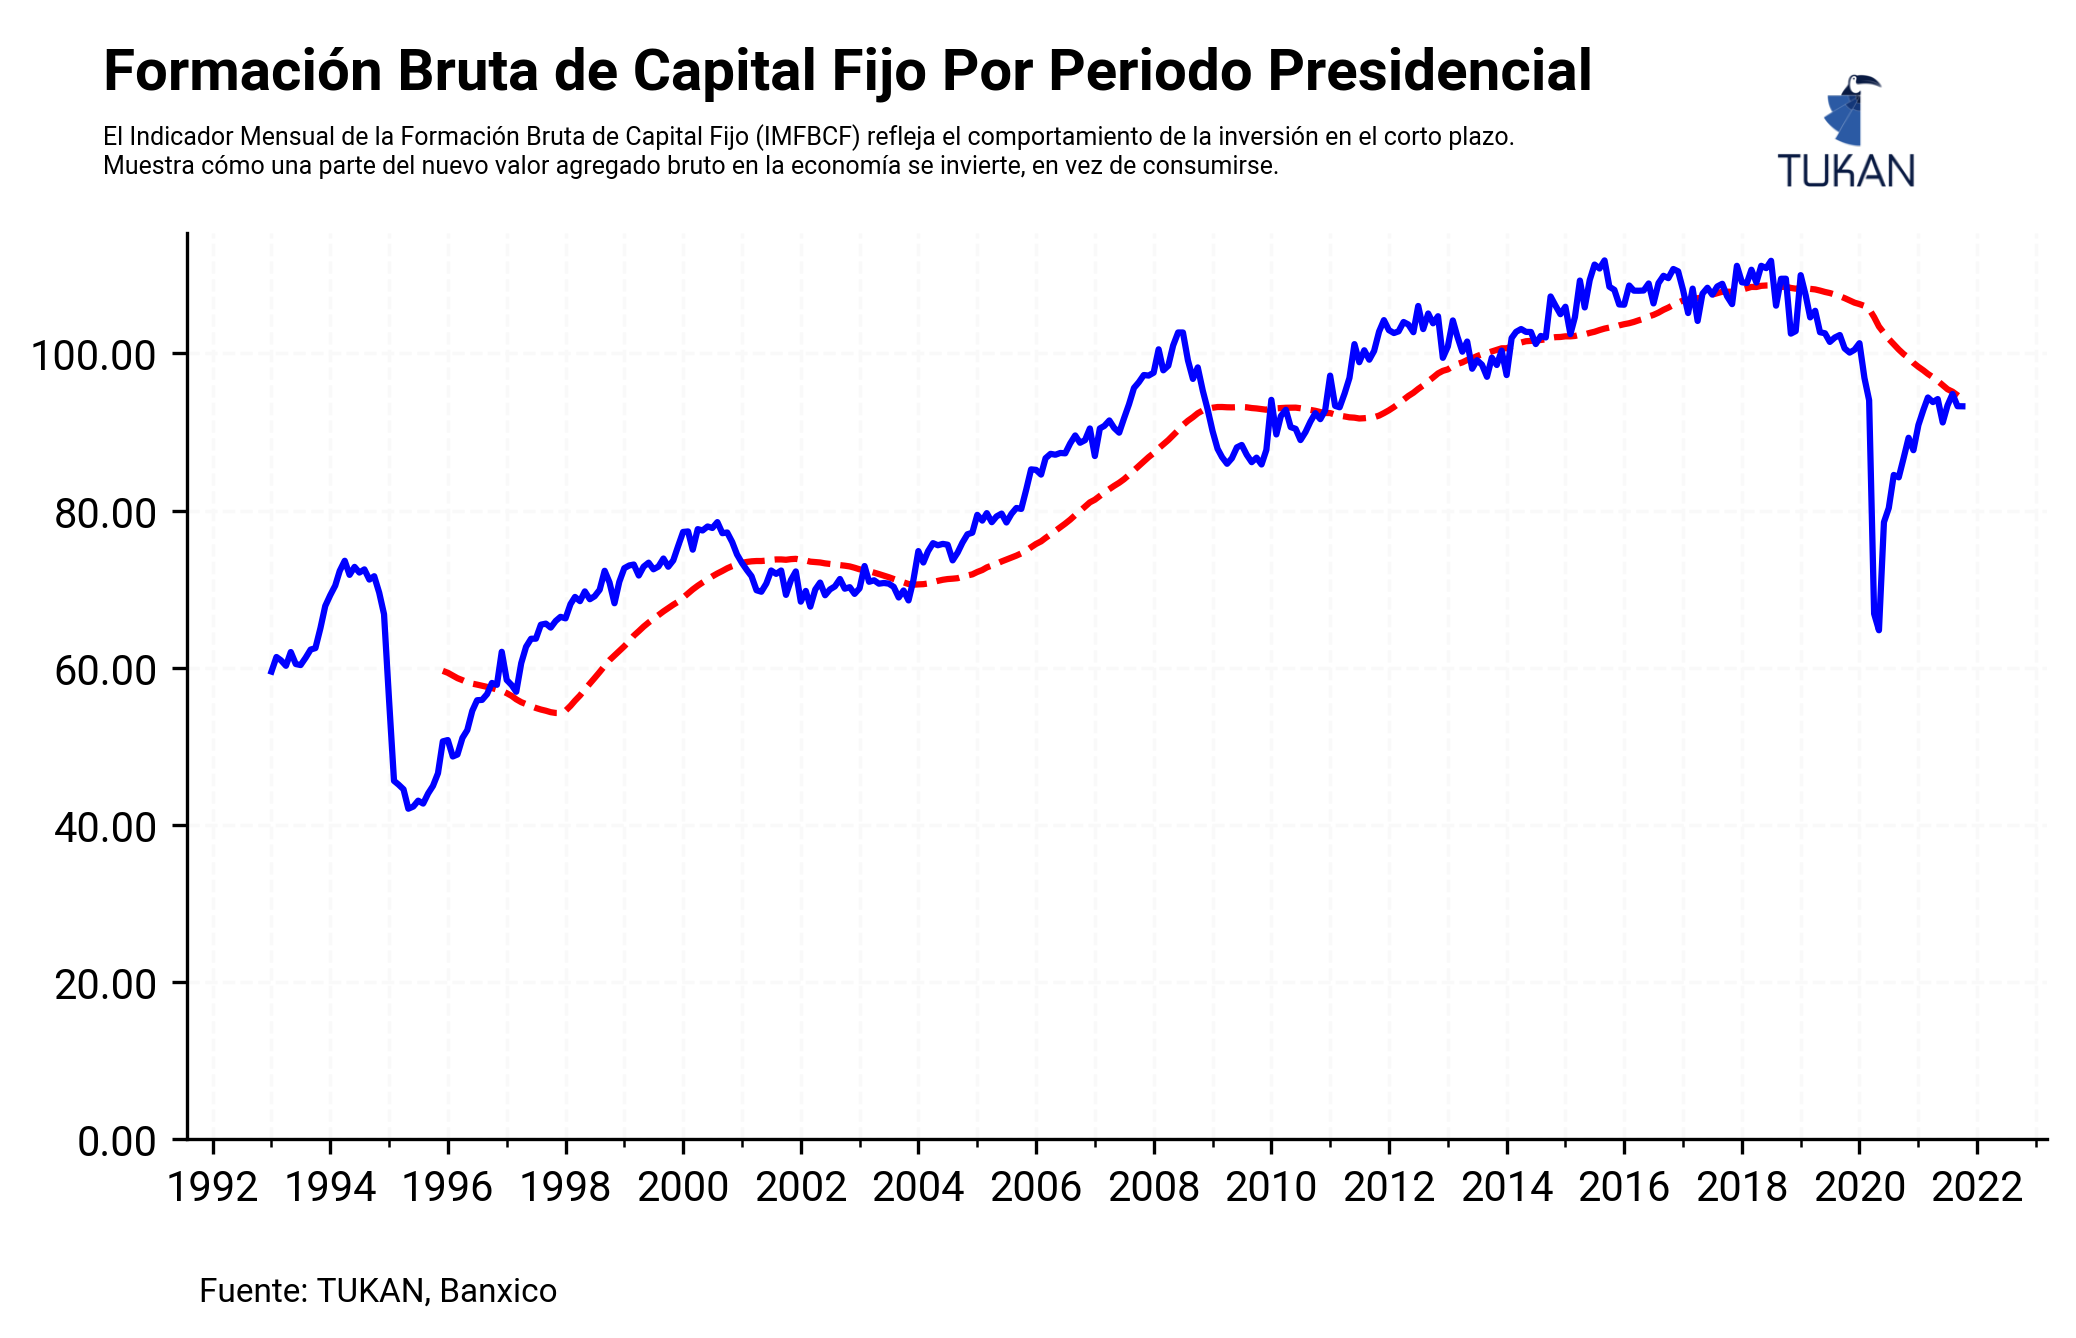

In [7]:
final_data = temp.copy()
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)


ax.plot(final_data["date"], final_data["ma_12m"], color = "red",  ls = "--")
ax.plot(final_data["date"], final_data["01a24841a9090de"], color = "blue")

# presidents = list(final_data["president"].unique())

# cmap = mpl.cm.get_cmap("GnBu_r", len(presidents) + 2)

# for index, x in enumerate(presidents):
#     ax.plot(final_data[final_data["president"] == x]["date"], final_data[final_data["president"] == x]["01a24841a9090de"], color = cmap(index))

#     X_max = final_data[final_data["president"] == x]["date"].max()
#     X_min = final_data[final_data["president"] == x]["date"].min()
#     center_date = X_min + ((X_max - relativedelta(months=2)) - X_min)/2

#     ax.vlines(X_max, ymin = 0, ymax = .35, color = "gray", ls = "--", lw = .75)
    # ax.text(x = center_date, y = .35,
    #         s = f"<{x}>",
    #         highlight_textprops=[{"color": cmap(index)}] ,
    #         ax = ax, weight = "bold", font = "Teko", ha = "center", size = 9)
 
ax.legend()
# ax.set_gid(color = "#dddddd")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.grid(visible=True, which='both', linestyle='--', color = "#f9f9f9")

ax.set_ylim(0)

fig.text(
    0.09,
    1,
    "Formación Bruta de Capital Fijo Por Periodo Presidencial",
    size=14,
    weight = "bold",
    font = "Roboto"
)
fig.text(
    0.09,
    0.93,
    "El Indicador Mensual de la Formación Bruta de Capital Fijo (IMFBCF) refleja el comportamiento de la inversión en el corto plazo.\nMuestra cómo una parte del nuevo valor agregado bruto en la economía se invierte, en vez de consumirse.",
    size=6
)
# Add footer
fig.text(0.13, -0.01, "Fuente: TUKAN, Banxico", fontsize=8)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/imfbcf_presidential_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.14, 0.17], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/imfbcf_presidential_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/imfbcf_presidential_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### Presidential plot

In [8]:
from highlight_text import HighlightText, ax_text, fig_text

In [9]:
# from highlight_text import ax_text

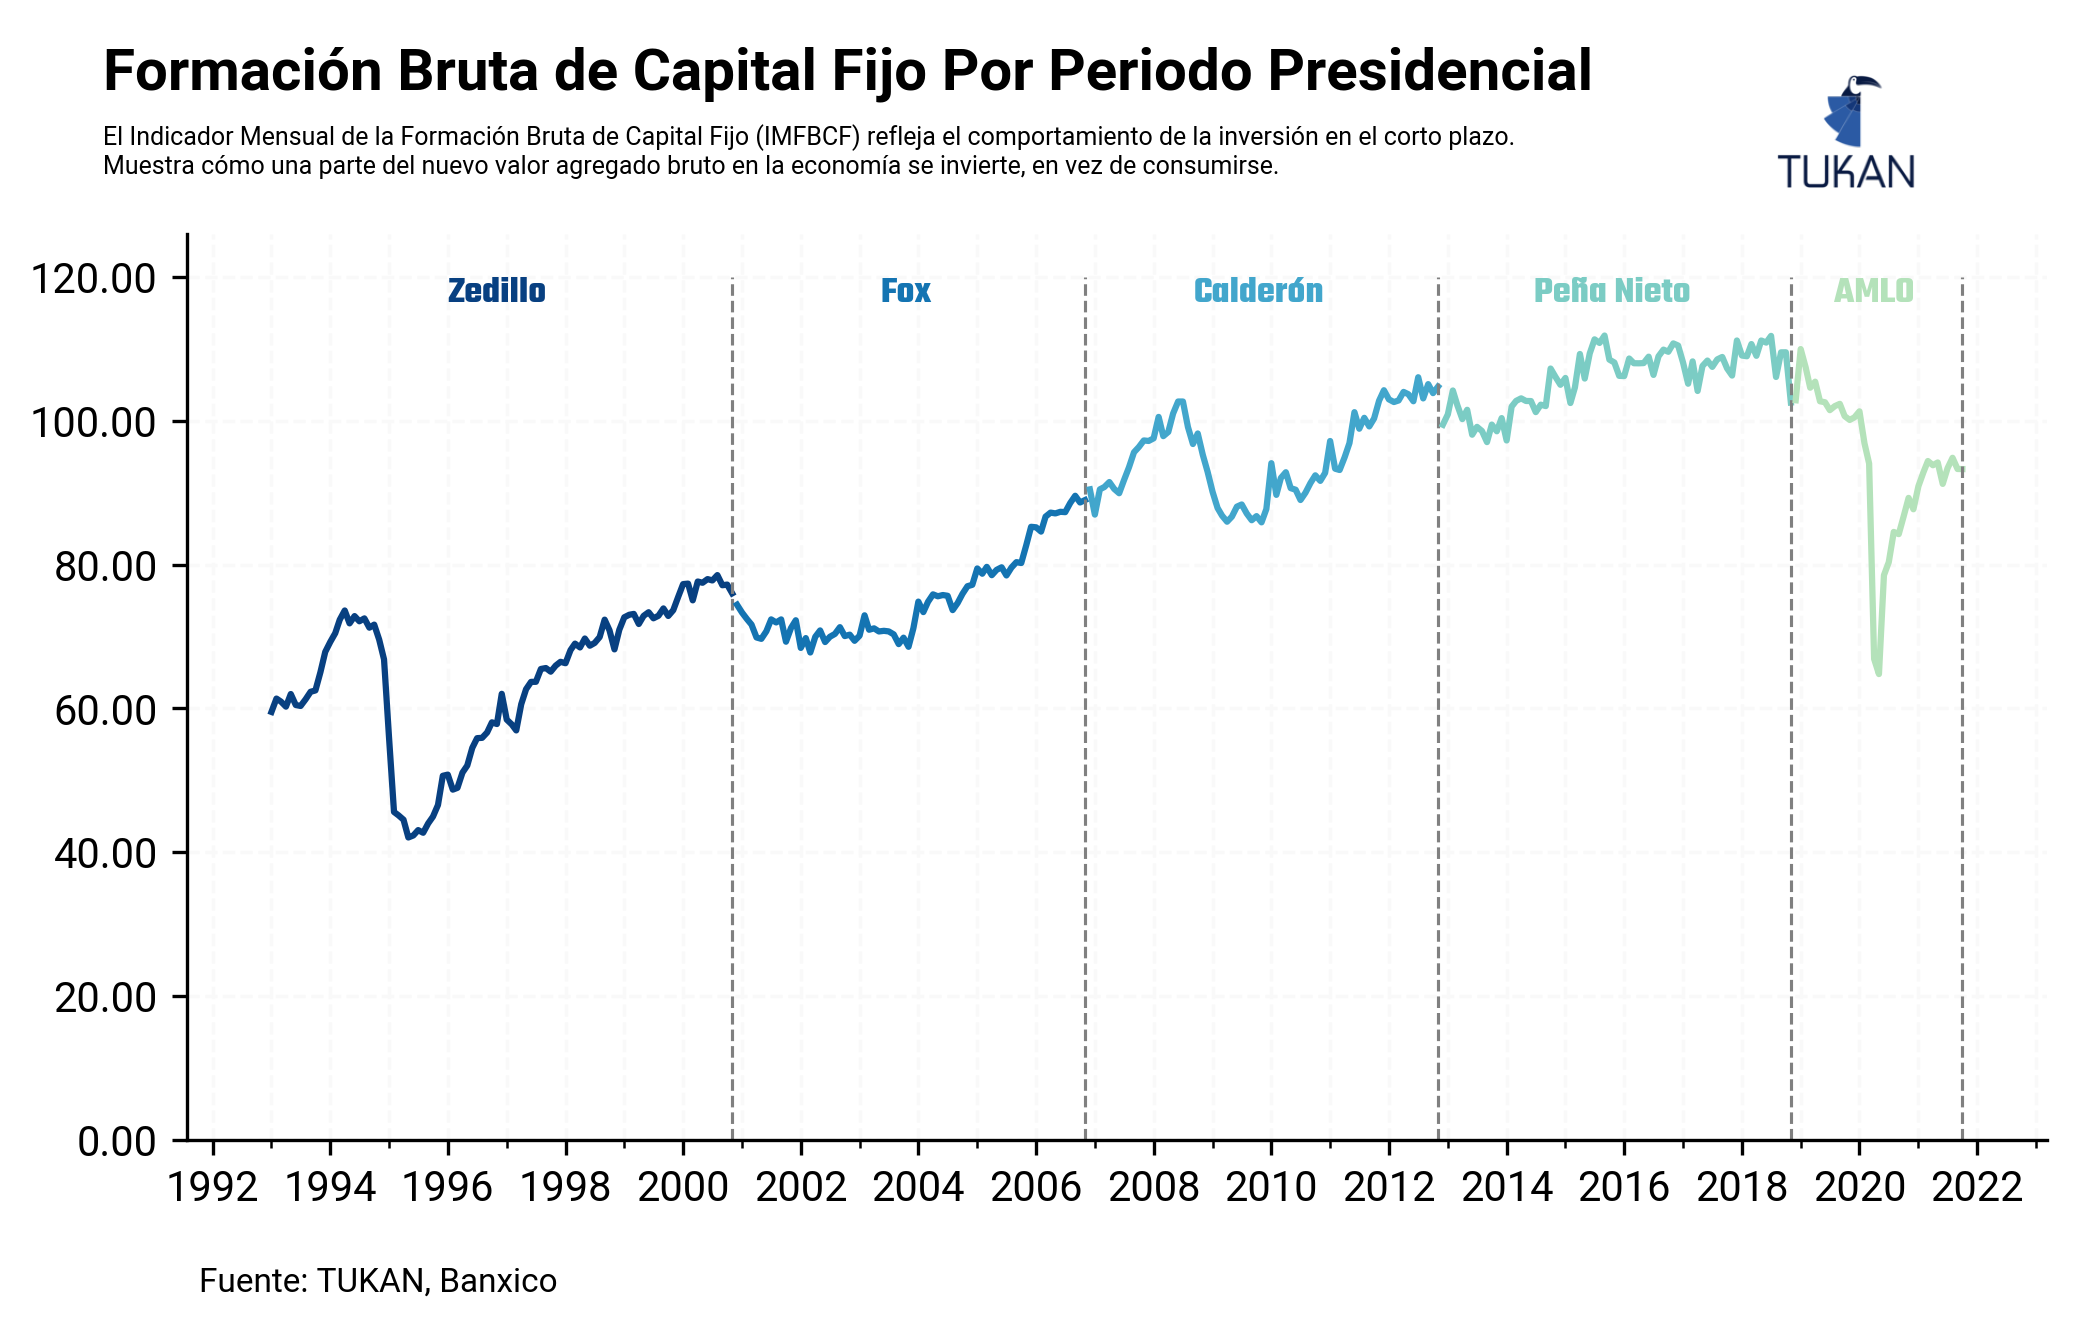

In [13]:
final_data = imfbcf.copy()
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

presidents = list(final_data["president"].unique())

cmap = mpl.cm.get_cmap("GnBu_r", len(presidents) + 2)

for index, x in enumerate(presidents):
    ax.plot(final_data[final_data["president"] == x]["date"], final_data[final_data["president"] == x]["01a24841a9090de"], color = cmap(index))

    X_max = final_data[final_data["president"] == x]["date"].max()
    X_min = final_data[final_data["president"] == x]["date"].min()
    center_date = X_min + ((X_max - relativedelta(months=2)) - X_min)/2

    ax.vlines(X_max, ymin = 0, ymax = 120, color = "gray", ls = "--", lw = .75)
    ax_text(x = center_date, y = 120,
            s = f"<{x}>",
            highlight_textprops=[{"color": cmap(index)}] ,
            ax = ax, weight = "bold", font = "Teko", ha = "center", size = 9)
 

# ax.set_gid(color = "#dddddd")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.grid(visible=True, which='both', linestyle='--', color = "#f9f9f9")

ax.set_ylim(0)

fig.text(
    0.09,
    1,
    "Formación Bruta de Capital Fijo Por Periodo Presidencial",
    size=14,
    weight = "bold",
    font = "Roboto"
)
fig.text(
    0.09,
    0.93,
    "El Indicador Mensual de la Formación Bruta de Capital Fijo (IMFBCF) refleja el comportamiento de la inversión en el corto plazo.\nMuestra cómo una parte del nuevo valor agregado bruto en la economía se invierte, en vez de consumirse.",
    size=6
)
# Add footer
fig.text(0.13, -0.001, "Fuente: TUKAN, Banxico", fontsize=8)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/imfbcf_presidential_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.14, 0.17], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/imfbcf_presidential_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/imfbcf_presidential_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)